### GAN is an example of unsupervised learning, it effectively supervises itself, and it consists of 2 sub-models.

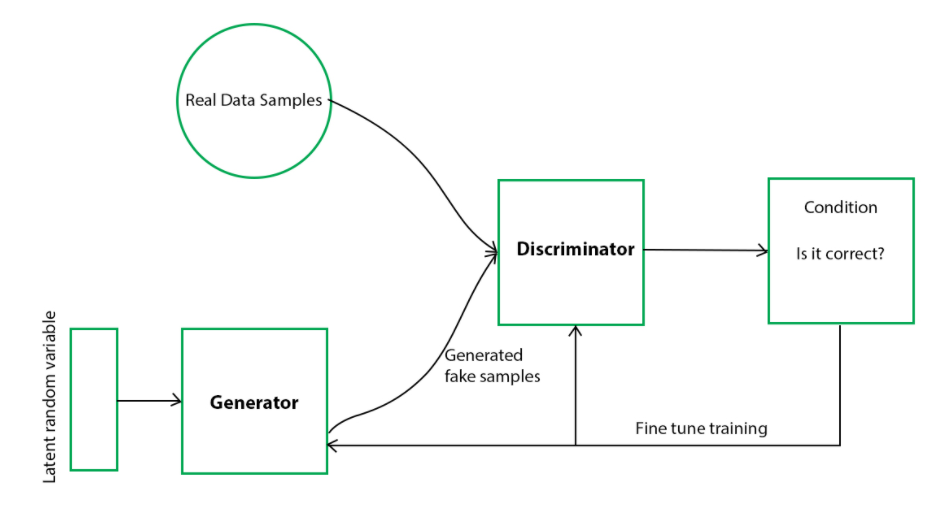

### There is a Generator sub-model and a discriminator sub-model

### The generator's job is to create fake input/examples...

### Discriminator's job is to take a sample and figure out if its a fake sample or a real one from the domain set.

### Keeps cycling until the generator can create a sample that is so convincing, that it can fool a discriminator.

### First, the discriminator is trained from the domain set, let's say images of flowers, its colours, shapes features, basically all attributes that make up a flower. Then we feed some non-flower images to make sure it can discriminate those images as 'not flowers'.

### When the discriminator gets good enough at recognizing things from the domain, then we apply the generator to create fake versions of the stuff in the domain (flowers).

### So the generator is gonna take a random input vector and use it to create its own (fake) flower. 

### This fake flower is sent to the discriminator, and it decides if its fake or from the domain.

### The answer is revealed to both the generator and the discriminator, and based upon that, the generator and the discriminator will change their parameters.

### Its a Zero-Sum game, there's always a winner and a loser.

### The winner does not change its parameters in that iteration where it won, whereas the loser has to update its model.

### So in the case where the generator wins (Creates something that fools the discriminator), the discriminator model will update itself to get better so that it is fooled less easily.

### This cycle continues until the generator becomes so good that the discriminator can no longer pick out the fakes, and at that point we would have built a successful generator.

### CNN's used as both generator and discriminator is a great way to recognize patterns in images.


### GAN's can be used in Video frame prediction, what the next move would look like, surveillance. Image enhancement.....etc.

In [18]:
import torch    # open-source machine learning library, a scientific computing framework.

import torch.nn as nn # torch. nn contains different classess that help you build neural network models.
                      # All models in PyTorch inherit from the subclass nn. Module ,
                      # which has useful methods like parameters() , __call__() and others.
        
import torch.optim as optim   # torch.optim is a package implementing various optimization algorithms.

import torchvision    # library for Computer Vision that goes hand in hand with PyTorch.
                     # It has utilities for efficient Image and Video transformations,
                     # some commonly used pre-trained models, and some datasets 
        
import torchvision.datasets as datasets

from torch.utils.data import DataLoader  # Dataloader keeps your data manageable and helps to
                                        # simplify your machine learning pipeline. a Dataset stores all your data, 
                                        # and Dataloader is can be used to iterate through the data, manage batches, 
                                        # transform the data, and much more.

import torchvision.transforms as transform  # common image transformations. They can be chained
                                            # together using Compose . A Tensor Image is a tensor with (C, H, W) shape,
                                            # where C is a number of channels, H and W are image height and width.

from torch.utils.tensorboard import SummaryWriter   #  is a suite of web applications for inspecting and 
                                                    # understanding your model runs and graphs. TensorBoard 
                                                    # currently supports five visualizations: 
        
# Things to try:
# Using larger networks
# Better normalizations with BatchNorm
# Different learning rate
# Changing architecture to CNN

### Creating the Discriminator

In [19]:
class Discriminator(nn.Module):
    def __init__(self, img_dim): # Gonna use the MNIST dataset, so the img_dim value is 784
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.1),  # In GANs, LeakyReLu is often times a better choice
            nn.Linear(128, 1),   # 128 to 1, cause we're just gonna output a single value, if its fake (0) or real (1)
            nn.Sigmoid(),        # To ensure its between 0 and 1
        )
        
        
    def forward(self, x):
        return self.disc(x)

### Creating the Generator

In [20]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim): # z_dim is the dimension of the latent noise for the generator's input.
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),  # 28*28*1 flattened --> 784, same as the real data dimension
            nn.Tanh(),  # To make sure that the output value is between -1 and 1, cause we're gonna normalize the input from
                        # the MNIST dataset to ensure that its between -1 and 1, so if the input is between -1 and 1,
                        # it only make sense that the ouptut from the generator should also be between -1 and 1.   
        )
        
        
    def forward(self, x):
        return self.gen(x)

### Hyperparameters and Training loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr = 3e-4   # 3e-4 is the bets learning rate for Adam, experience.

z_dim = 64  # We can try 128, 256 or smaller dims as well

image_dim = 28*28*1  # 784

batch_size = 32

num_epochs = 100

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

fixed_noise = torch.randn(batch_size, z_dim).to(device)  # we need this to see how it has changed across th epochs.
                                                         # we'll use the tensorboard for visualization

transforms = transform.Compose(
    [transform.ToTensor(), transform.Normalize((0.5,), (0.5,)),]
)

dataset = datasets.MNIST(root="dataset/", transform = transforms, download = True )

loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

opt_disc =  optim.Adam(disc.parameters(), lr = lr)
opt_gen = optim.Adam(gen.parameters(), lr = lr)

criterion = nn.BCELoss()

# This writer is only gonna ouput fake images, the generator's generation
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")

# for real images
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _ ) in enumerate(loader):  # Notice the _ , cause we dont need the labels, Unsupervised.
        
        # real before has shape (batch size, number of parameters (columns))
        real = real.view(-1, 784).to(device)  # -1 so that we can keep the number of examples in our batch, 784 to flatten
                                              # everything else
        batch_size = real.shape[0]
        
        #
        #
        # Training Discriminator: max log(D(real)) + log(1-D(G(z)))
        #
        #  we want the discriminator to estimate the *probability that its input is real*. 
        # Therefore the desired output for disc(real) is 1, and 0 for disc(fake).
        
        
        # Generating noise
        noise = torch.randn(batch_size, z_dim).to(device) # Gaussian distribution, mean 0, std dev 1
        
        # Generate fake images
        fake = gen(noise)  # we have to re-utilise this value later
        
        # log(D(real)) part of the loss function
        disc_real = disc(real).view(-1)
        
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) #Ones because its always gonna be real, 1, maximizing
        
        # log(1-D(G(z))) part of the loss function
        disc_fake = disc(fake).view(-1)
        
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        lossD = (lossD_real + lossD_fake) / 2
        
        disc.zero_grad()
        
        lossD.backward(retain_graph = True)
        
        opt_disc.step()
        
        #
        #
        # Training the Generator min log(1 - D(G(z))) ("This expression leads to saturating/Weak gradients, 
        # which leads to slower/No training")    <-- alternative -----> max log(D(G(z)))  <--Trying to maximise this....
        #
        
        output = disc(fake).view(-1)
        
        lossG = criterion(output, torch.ones_like(output))
        
        gen.zero_grad()
        
        lossG.backward()
        
        opt_gen.step()
        
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
            
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

---